In [11]:
from pyspark import SparkContext
import datetime
from csv import reader
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
%matplotlib inline
matplotlib.style.use('ggplot')

In [12]:
sc = SparkContext()
filepath = r'./NYPD_Complaint_Data_Historic.csv'
df = sc.textFile(filepath).map(lambda l: reader([l]).__next__())
header = df.first()
df = df.filter(lambda line: line != header).cache() # filter out header

### Data Cleaning

In [13]:
def transform(array):
    array[1] = datetime.datetime.strptime(array[1], '%m/%d/%Y')
    array[2] = datetime.datetime.strptime(array[2], '%H:%M:%S').time()
    return array

#replace year 1015
def replaceYear2015to2015(array):
    array[1] = array[1].replace('1015', '2015')
    return array

def replaceTime24to00(array):
    array[2] = array[2].replace('24:00:00', '00:00:00')
    return array

t = df.filter(lambda array: array[1] != '' and array[2] != '') \
    .map(replaceYear2015to2015) \
    .map(replaceTime24to00) \
    .map(transform) \
    .filter(lambda array: (array[1].year >= 2006 and array[1].year <= 2015))

In [14]:
def timeMap(x):
    if x[0].hour >= 0 and x[0].hour < 6:
        return ('Midnight',1)
    elif x[0].hour >= 6 and x[0].hour < 12:
        return ('Morning', 1)
    elif x[0].hour >= 12 and x[0].hour < 18:
        return ('Afternoon', 1)
    else:
        return ('Evening', 1)

timeCount = t.map(timeMap) \
            .reduceByKey(lambda x, y: x + y) \

### Assumption 1: The correlation about the time period and the crime inside the residence

In [16]:
# This operation return the statistic data that crime occur inside the residence
assump_1 = t.map(lambda x: (x[2], x[15], x[16]))\
            .filter(lambda x: 'INSIDE' in str(x[1]) and 'RESIDENCE' in str(x[2]))\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [17]:
assump_1_data = assump_1.collect()

In [18]:
assump_1_data

[('Afternoon', 465993),
 ('Morning', 356396),
 ('Midnight', 243796),
 ('Evening', 469017)]

In [19]:
type(assump_1_data)

list

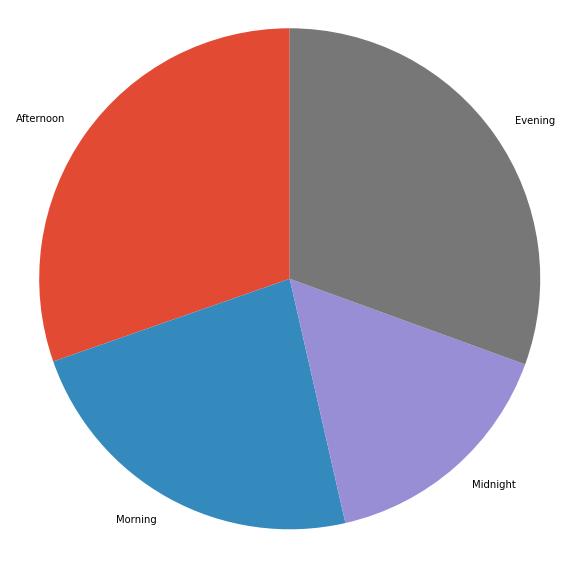

In [21]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_1_data)[:, 1], labels = np.array(assump_1_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(10,10)